# ATP Tennis Data - Feature Engineering Based on Dataset 1


I'm noticing significant difference in model performance after fixing a bug when calculating diff data.

The bug:

```
p1_rank_diff = p1_rank - p2_age
```

Previously, Decision Tree had 92% accuracy and Grandient Boosting had 85% accuracy. As you would imagine with over 300 ranked the difference in this number can be pretty high and since the data only applied to player 1, this would skew our data by a lot.

When I ran the fixed dataset again, Decision Tree got 56% and Gradient Boosting got around 66%.

Unfortunately, when I created the initial dataset, I did not set the random seed of np.random so the winner placement was different than the initial dataset.

In this notebook, I will take the original dataset's placement of winner and re-create the dataset. I want to verify that winner placement does not have significant effect on our models to verify my feature engineering technique. If the model accuracy is approximately the same, then we have verified this.

NOTE: Dataset we are using for this comparison is the diff data where were subtract player 2 stats from player 1

# Results

Decision Tree Accuracy: 56%
Grandient Boosting Accuracy: 65.5%



In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import json
import random
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util.model_util import RSTATE
random.seed(RSTATE)


%matplotlib inline
sns.set()

In [32]:
# Contants
START_YEAR = 1985
END_YEAR = 2019

DATASET_DIR = '../datasets'
MODEL_DIR = '../models'

TEST = False

if TEST:
    PREPROCESSED_FILE = f'{DATASET_DIR}/test-preprocessed.csv'
    FEATURE_FILE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test.csv'
    FEATURE_FILE_DIFF = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test-diff.csv'
    FEATURE_FILE_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test-ohe.csv'
    FEATURE_FILE_DIFF_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test-diff-ohe.csv'
    FEATURE_FILE_RAW_DIFF_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test-raw_diff-ohe.csv'
else:
    # this is the file we generated from our pre-processing notebook
    PREPROCESSED_FILE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_preprocessed.csv'
    BASE_FILE = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff.csv.bak.csv'
    FEATURE_FILE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features.verify.csv'
    FEATURE_FILE_DIFF = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features-diff.veritfy.csv'
    FEATURE_FILE_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features-ohe.verify.csv'
    FEATURE_FILE_DIFF_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features-diff-ohe.veritfy.csv'
    FEATURE_FILE_RAW_DIFF_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features-raw_diff-ohe.verify.csv'



In [33]:
pre = pd.read_csv(PREPROCESSED_FILE, parse_dates=["tourney_date"])



In [34]:
base= pd.read_csv(BASE_FILE)
base = base.reindex(sorted(base.columns), axis=1)
base.to_csv(BASE_FILE, index=False)

base_label = base["p1_winner"]

In [35]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 45 columns):
tourney_id       99955 non-null object
tourney_name     99955 non-null object
surface          99955 non-null object
draw_size        99955 non-null float64
tourney_level    99955 non-null object
tourney_date     99955 non-null datetime64[ns]
match_num        99955 non-null int64
winner_id        99955 non-null int64
winner_seed      99955 non-null float64
winner_name      99955 non-null object
winner_hand      99955 non-null object
winner_ht        99955 non-null float64
winner_ioc       99955 non-null object
winner_age       99955 non-null float64
loser_id         99955 non-null int64
loser_seed       99955 non-null float64
loser_name       99955 non-null object
loser_hand       99955 non-null object
loser_ht         99955 non-null float64
loser_ioc        99955 non-null object
loser_age        99955 non-null float64
score            99951 non-null object
best_of          9995

## Let's look at the data to make sure all the types are correct before we being

In [36]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 45 columns):
tourney_id       99955 non-null object
tourney_name     99955 non-null object
surface          99955 non-null object
draw_size        99955 non-null float64
tourney_level    99955 non-null object
tourney_date     99955 non-null datetime64[ns]
match_num        99955 non-null int64
winner_id        99955 non-null int64
winner_seed      99955 non-null float64
winner_name      99955 non-null object
winner_hand      99955 non-null object
winner_ht        99955 non-null float64
winner_ioc       99955 non-null object
winner_age       99955 non-null float64
loser_id         99955 non-null int64
loser_seed       99955 non-null float64
loser_name       99955 non-null object
loser_hand       99955 non-null object
loser_ht         99955 non-null float64
loser_ioc        99955 non-null object
loser_age        99955 non-null float64
score            99951 non-null object
best_of          9995

In [37]:
pre.sample(5).T

,87037,56453,93065,50418,45589
tourney_id,2014-407,2003-433,2016-6120,2001-506,1999-540
tourney_name,rotterdam,scottsdale,nice,buenos aires,wimbledon
surface,hard,hard,clay,clay,grass
draw_size,32,32,32,32,128
tourney_level,a,a,a,a,g
tourney_date,2014-02-10 00:00:00,2003-03-03 00:00:00,2016-05-16 00:00:00,2001-02-19 00:00:00,1999-06-21 00:00:00
match_num,23,3,298,14,51
winner_id,105227,103324,100644,102287,101820
winner_seed,20,25,8,11,27
winner_name,marin cilic,arnaud di pasquale,alexander zverev,albert portas,marc rosset


# Tournament Info

* tournament id - extract from current tourney_id field
* tournament level - one hot encode
* month of tournament - extract from tourney_date
* year of tournament - extract from tourney_date
* surface - one hot encode
* draw size
* best of


### Extract tournment ID aand Encode

Since players may have an affinity for certainly tournaments because of location or conditions, we should include this into our features

First let's rename the columns since it's rather confusing - currently, tourney_id is a composite of {year}-{id}. ID is alphanumeric so we need to encode these

In [38]:
matches = pre
matches = matches.rename({"tourney_id": "tourney_year_plus_id"}, axis=1)
matches["tourney_id"] = matches.tourney_year_plus_id.apply(lambda x: x.split("-")[1])
matches.sample(5, random_state=RSTATE).tourney_id

57294    311
20858    434
17975    440
21211    520
89342    301
Name: tourney_id, dtype: object

In [39]:


tidle = LabelEncoder()
tid_labels = tidle.fit_transform(matches['tourney_id'])
tid_map = {label: num for num, label in enumerate(tidle.classes_)}
print(tid_map)

matches["tourney_id_label"] = matches["tourney_id"].map(tid_map)

# save off map to be used later
with open(f'{MODEL_DIR}/tid_map.json', 'w') as file:
    json.dump(tid_map, file)
    
matches.sample(5)[["tourney_id", "tourney_id_label"]]

{'0301': 0, '0308': 1, '0311': 2, '0314': 3, '0315': 4, '0316': 5, '0319': 6, '0321': 7, '0322': 8, '0328': 9, '0329': 10, '0337': 11, '0341': 12, '0352': 13, '0360': 14, '0375': 15, '0402': 16, '0407': 17, '0410': 18, '0414': 19, '0421': 20, '0424': 21, '0425': 22, '0429': 23, '0439': 24, '0451': 25, '0495': 26, '0496': 27, '0499': 28, '0500': 29, '0506': 30, '0533': 31, '0568': 32, '0605': 33, '0717': 34, '0741': 35, '0773': 36, '0891': 37, '1536': 38, '1720': 39, '201': 40, '215': 41, '224': 42, '2276': 43, '237': 44, '240': 45, '301': 46, '302': 47, '303': 48, '304': 49, '305': 50, '306': 51, '308': 52, '309': 53, '310': 54, '311': 55, '312': 56, '313': 57, '314': 58, '315': 59, '316': 60, '317': 61, '318': 62, '319': 63, '321': 64, '322': 65, '323': 66, '325': 67, '326': 68, '327': 69, '328': 70, '329': 71, '330': 72, '332': 73, '3348': 74, '336': 75, '337': 76, '338': 77, '339': 78, '341': 79, '3465': 80, '348': 81, '352': 82, '354': 83, '357': 84, '359': 85, '360': 86, '366': 87

,tourney_id,tourney_id_label
85045,1536,38
13437,401,91
54735,317,61
42303,311,55
42891,422,111


### Tournament Level

Tournament level does have some type of implicit ordinality to them since tournaments are worth different points according to their levels with 'g' (grand slams) worth the most number of points

We will do a custom encoding for these

Here are the point values for winner the levels:
* g - grand slam - 2000
* f - tour final - 1500
* m - masters - 1000
* a - other tour event - anywhere between 250 to 500 depending on the series

In [40]:
np.unique(matches.tourney_level)

array(['a', 'f', 'g', 'm'], dtype=object)

In [41]:
import json

level_map = {'g': 1, 'f': 2, 'm': 3, 'a': 4}
matches["tourney_level_label"] = matches['tourney_level'].map(level_map)
# let's check our work
matches.sample(5)[["tourney_level", "tourney_level_label"]]

# let's save off the map for later use
with open(f'{MODEL_DIR}/tourney_level_map.json', 'w') as file:
    json.dump(level_map, file)

### Tournamant year and Month

We can extract this from the tourney_date

In [42]:
matches["tourney_year"] = matches.tourney_date.dt.year
matches["tourney_month"] = matches.tourney_date.dt.month
matches.sample(5)[["tourney_year", "tourney_month", "tourney_date"]]

,tourney_year,tourney_month,tourney_date
81232,2011,11,2011-11-07
81079,2011,10,2011-10-17
85082,2013,5,2013-05-12
55056,2002,8,2002-08-12
13804,1990,4,1990-04-02


### Tournament Surface

There is no ordinality here so we can just use a label encoder

In [43]:

surface_le = LabelEncoder()
surface_labels = surface_le.fit_transform(matches['surface'])
surface_map = {label: num for num, label in enumerate(surface_le.classes_)}
print(surface_map)

matches["surface_label"] = matches["surface"].map(surface_map)

# save off map to be used later
with open(f'{MODEL_DIR}/surface_map.json', 'w') as file:
    json.dump(surface_map, file)
    
matches.sample(5)[["surface", "surface_label"]]

{'carpet': 0, 'clay': 1, 'grass': 2, 'hard': 3}


,surface,surface_label
28253,clay,1
18212,clay,1
32426,clay,1
27481,carpet,0
62772,clay,1


# Generate Player Features

Most are already numbers that we can feed into the model - we will just keep these for now

### Player origin (ioc)

Again there is no ordinality to this so we will use the LabelEncoder

In [44]:
ioc_le = LabelEncoder()
# we have to append loser and winner list to get comprehensive list
ioc_labels = ioc_le.fit_transform(matches["loser_ioc"].append(matches["winner_ioc"]))
ioc_map = {label: num for num, label in enumerate(ioc_le.classes_)}
print(ioc_map)

matches["loser_ioc_label"] = matches["loser_ioc"].map(ioc_map)
matches["winner_ioc_label"] = matches["winner_ioc"].map(ioc_map)

# save off map to be used later
with open(f'{MODEL_DIR}/ioc_map.json', 'w') as file:
    json.dump(ioc_map, file)
    
matches.sample(5)[["loser_ioc", "loser_ioc_label", "winner_ioc", "winner_ioc_label"]]

{'alg': 0, 'arg': 1, 'arm': 2, 'aus': 3, 'aut': 4, 'aze': 5, 'bah': 6, 'bar': 7, 'bel': 8, 'ben': 9, 'ber': 10, 'bih': 11, 'blr': 12, 'bol': 13, 'bra': 14, 'bul': 15, 'can': 16, 'chi': 17, 'chn': 18, 'civ': 19, 'col': 20, 'crc': 21, 'cro': 22, 'cub': 23, 'cyp': 24, 'cze': 25, 'den': 26, 'dom': 27, 'ecu': 28, 'egy': 29, 'esa': 30, 'esp': 31, 'est': 32, 'fin': 33, 'fra': 34, 'gbr': 35, 'geo': 36, 'ger': 37, 'gre': 38, 'hai': 39, 'hkg': 40, 'hun': 41, 'ina': 42, 'ind': 43, 'iri': 44, 'irl': 45, 'isr': 46, 'ita': 47, 'jam': 48, 'jpn': 49, 'kaz': 50, 'ken': 51, 'kor': 52, 'kuw': 53, 'lat': 54, 'ltu': 55, 'lux': 56, 'mar': 57, 'mas': 58, 'mda': 59, 'mex': 60, 'mkd': 61, 'mon': 62, 'ned': 63, 'ngr': 64, 'nor': 65, 'nzl': 66, 'pak': 67, 'par': 68, 'per': 69, 'phi': 70, 'pol': 71, 'por': 72, 'pur': 73, 'qat': 74, 'rou': 75, 'rsa': 76, 'rus': 77, 'sen': 78, 'slo': 79, 'srb': 80, 'sui': 81, 'svk': 82, 'swe': 83, 'tha': 84, 'tog': 85, 'tpe': 86, 'tun': 87, 'tur': 88, 'uae': 89, 'ukr': 90, 'unk': 9

,loser_ioc,loser_ioc_label,winner_ioc,winner_ioc_label
37411,nor,65,aut,4
50117,ger,37,swe,83
89956,ita,47,srb,80
9609,bel,8,aus,3
46748,swe,83,aus,3


### Player Hand - (l/r/u)

This is simple categorial data - will use LabelEncoder

In [45]:
hand_le = LabelEncoder()
# we have to append loser and winner list to get comprehensive list
hand_labels = hand_le.fit_transform(matches["loser_hand"].append(matches["winner_hand"]))
hand_map = {label: num for num, label in enumerate(hand_le.classes_)}
print(hand_map)

matches["loser_hand_label"] = matches["loser_hand"].map(hand_map)
matches["winner_hand_label"] = matches["winner_hand"].map(hand_map)

# save off map to be used later
with open(f'{MODEL_DIR}/hand_map.json', 'w') as file:
    json.dump(hand_map, file)
    
matches.sample(9)[["loser_hand", "loser_hand_label", "winner_hand", "winner_hand_label"]]

{'l': 0, 'r': 1, 'u': 2}


,loser_hand,loser_hand_label,winner_hand,winner_hand_label
26782,r,1,r,1
22938,r,1,l,0
90382,r,1,r,1
27265,r,1,r,1
72037,r,1,r,1
96374,r,1,r,1
7956,r,1,r,1
56250,r,1,r,1
39441,r,1,l,0


## Match Features

Only feature we will use for now is round. There is an ordinality to the rounds so we will use a custome encoding

Couple issues with this:

'rr' - means round robin. This usually means that all players in a tournament is divided into multiple flights (ie, 2). All players in the flight play against each other. The year end final for instance has 8 players. Top 2 players from each flight make it to semi finals. Winner of that match goes to finals. So rr could mean any of the 3 matches a player would play in the flight. We will just pick the next unique number to encode this.

https://en.wikipedia.org/wiki/ATP_Finals

'br' - Not sure what this indicates. Will encode this as the last value

<red>try one hot encoding and see the effect</red>

In [46]:
np.unique(matches["round"])

array(['br', 'f', 'qf', 'r128', 'r16', 'r32', 'r64', 'rr', 'sf'],
      dtype=object)

In [47]:
round_map = {'f': 1, 
            'sf': 2,
            'qf': 3,
            'r16': 4,
            'r32': 5,
            'r64': 6,
            'r128': 7,
            'rr': 8,
            'br': 9}
matches["round_label"] = matches["round"].map(round_map)

# save off map to be used later
with open(f'{MODEL_DIR}/round_map.json', 'w') as file:
    json.dump(round_map, file)
    
matches.sample(5)[["round", "round_label"]]


,round,round_label
21484,r128,7
4967,r32,5
52112,r64,6
46057,r32,5
62595,r64,6


# Let's check out our data one more time

In [48]:
matches.sample(5).T

,45904,42128,42991,64972,50388
tourney_year_plus_id,1999-439,1998-520,1998-419,2006-2276,2001-505
tourney_name,umag,roland garros,indianapolis,zagreb,vina del mar
surface,clay,clay,hard,carpet,clay
draw_size,32,128,64,32,32
tourney_level,a,g,a,a,a
tourney_date,1999-07-26 00:00:00,1998-05-25 00:00:00,1998-08-17 00:00:00,2006-01-30 00:00:00,2001-02-12 00:00:00
match_num,21,61,15,29,15
winner_id,101543,102271,102882,103344,103900
winner_seed,15,45,11,1,29
winner_name,jeff tarango,hicham arazi,mark philippoussis,ivan ljubicic,david nalbandian


# 1 - Generate Features and Ground Truth

This is going to be a little bit tricky. If we leave the columns as it, all of our labels for winner/loser would be 1 since winner column is first.

Instead, we are going to have to loop through all rows and randomly place winner or loser as player 1 so that we can have labels that are both 0 and 1

In [49]:

tourney_cols = ["tourney_id", "tourney_id_label", "tourney_level", "tourney_level_label", "tourney_year", "tourney_month", "surface", "surface_label", "draw_size", "round", "round_label", "best_of"]

def generate_feature_row(idx: int, row: pd.Series, p1winner: bool) -> dict:
    if idx % 10000 == 0:
        print(f'Processing index {idx}')
    
    m = {}
    # first add static columns for tournament and match
    for tc in tourney_cols:
        m[tc] = row[tc]
        
    # now depending on what random gives us either put winner as p1 or loser as p1
    m1 = {}
    if p1winner:
        m1 = {
            "p1": row.winner_id,
            "p1_rank": row.winner_rank,
            "p1_ht": row.winner_ht,
            "p1_ioc": row.winner_ioc,
            "p1_ioc_label": row.winner_ioc_label,
            "p1_age": row.winner_age,
            "p1_seed": row.winner_seed,
            "p1_hand": row.winner_hand,
            "p1_hand_label": row.winner_hand_label,
            "p2": row.loser_id,
            "p2_rank": row.loser_rank,
            "p2_ht": row.loser_ht,
            "p2_ioc": row.loser_ioc,
            "p2_ioc_label": row.loser_ioc_label,
            "p2_age": row.loser_age,
            "p2_seed": row.loser_seed,
            "p2_hand": row.loser_hand,
            "p2_hand_label": row.loser_hand_label,
            "p1_winner": 1,
            "rank_diff": row.winner_rank - row.loser_rank,
            "ht_diff": row.winner_ht - row.loser_ht,
            "age_diff": row.winner_age - row.loser_age,
            "seed_diff": row.winner_seed - row.loser_seed,

        }
    else:
        m1 = {
            "p1": row.loser_id,
            "p1_rank": row.loser_rank,
            "p1_ht": row.loser_ht,
            "p1_ioc": row.loser_ioc,
            "p1_ioc_label": row.loser_ioc_label,
            "p1_age": row.loser_age,
            "p1_seed": row.loser_seed,
            "p1_hand": row.loser_hand,
            "p1_hand_label": row.loser_hand_label,
            "p2": row.winner_id,
            "p2_rank": row.winner_rank,
            "p2_ht": row.winner_ht,
            "p2_ioc": row.winner_ioc,
            "p2_ioc_label": row.winner_ioc_label,
            "p2_age": row.winner_age,
            "p2_seed": row.winner_seed,
            "p2_hand": row.winner_hand,
            "p2_hand_label": row.winner_hand_label,
            "p1_winner": 0,
            "rank_diff": row.loser_rank - row.winner_rank,
            "ht_diff": row.loser_ht - row.winner_ht,
            "age_diff": row.loser_age - row.winner_age,
            "seed_diff": row.loser_seed - row.winner_seed,
        }
    m.update(m1)
    return m

features = pd.DataFrame()
for idx, row in matches.iterrows():
    d = generate_feature_row(idx, row, int(base_label.iloc[idx]) == 1)
    features = features.append(d, ignore_index=True)
    if TEST and idx == 500:
        break
    

features = features.reindex(sorted(features.columns), axis=1)
features.info()

Processing index 0
Processing index 10000
Processing index 20000
Processing index 30000
Processing index 40000
Processing index 50000
Processing index 60000
Processing index 70000
Processing index 80000
Processing index 90000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 35 columns):
age_diff               99955 non-null float64
best_of                99955 non-null float64
draw_size              99955 non-null float64
ht_diff                99955 non-null float64
p1                     99955 non-null float64
p1_age                 99955 non-null float64
p1_hand                99955 non-null object
p1_hand_label          99955 non-null float64
p1_ht                  99955 non-null float64
p1_ioc                 99955 non-null object
p1_ioc_label           99955 non-null float64
p1_rank                99955 non-null float64
p1_seed                99955 non-null float64
p1_winner              99955 non-null float64
p2                     

In [50]:
type_map = {
    "tourney_id_label": np.int32,
    "tourney_level_label": np.int32,
    "tourney_year": np.int32,
    "tourney_month": np.int32,
    "surface_label": np.int32,
    "draw_size": np.int32,
    "round_label": np.int32,
    "p1": np.int32,
    "p1_rank": np.int32,
    "p1_ioc_label": np.int32,
    "p1_seed": np.int32,
    "p1_hand_label": np.int32,
    "p2": np.int32,
    "p2_rank": np.int32,
    "p2_ioc_label": np.int32,
    "p2_seed": np.int32,
    "p2_hand_label": np.int32,
    "p1_winner": np.int32,
    "rank_diff": np.int32,
    "ht_diff": np.int32,
    "age_diff": np.int32,
    "seed_diff": np.int32,
    "best_of": np.int32,
}

features = features.astype(type_map)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 35 columns):
age_diff               99955 non-null float64
best_of                99955 non-null int32
draw_size              99955 non-null int32
ht_diff                99955 non-null int32
p1                     99955 non-null int32
p1_age                 99955 non-null float64
p1_hand                99955 non-null object
p1_hand_label          99955 non-null int32
p1_ht                  99955 non-null float64
p1_ioc                 99955 non-null object
p1_ioc_label           99955 non-null int32
p1_rank                99955 non-null int32
p1_seed                99955 non-null int32
p1_winner              99955 non-null int32
p2                     99955 non-null int32
p2_age                 99955 non-null float64
p2_hand                99955 non-null object
p2_hand_label          99955 non-null int32
p2_ht                  99955 non-null float64
p2_ioc                 99955 non-null obje

In [51]:
features.sample(5).T

,29736,27268,3083,14853,56620
age_diff,4,7.49,4.53,6.08,-1.95
best_of,3,3,5,3,3
draw_size,32,32,128,32,128
ht_diff,-8,-21,-10,-12,-5
p1,101150,100923,100836,100942,103819
p1_age,29.24,30.74,24.58,26.99,21.6
p1_hand,l,r,r,r,r
p1_hand_label,0,1,1,1,1
p1_ht,180,180,175,178,185
p1_ioc,ita,aus,can,fra,sui


In [52]:
# verify that seed diff is <= rank diff
features[abs(features.seed_diff) > abs(features.rank_diff)][["seed_diff", "rank_diff"]]

,seed_diff,rank_diff
274,-6,-5
765,-5,3
774,-2,-1
953,-5,4
1155,3,1
...,...,...
99365,-14,-12
99368,-15,-13
99472,3,1
99768,7,5


### Save to File

In [53]:
# fix this.. this is not right yet
raw_feature_columns = ["best_of", "draw_size", "round_label", "surface_label", "tourney_id_label", "tourney_level_label", "tourney_month", "tourney_year",
                   "p1", "p1_age", "p1_hand_label", "p1_ht", "p1_ioc_label", "p1_rank", "p1_seed", 
                   "p2", "p2_age", "p2_hand_label", "p2_ht", "p2_ioc_label", "p2_rank", "p2_seed", 
                   "p1_winner"
                  ]
diff_columns = ["best_of", "draw_size", "round_label", "surface_label", "tourney_id_label", "tourney_level_label", "tourney_month", "tourney_year",
                   "p1", "p1_hand_label", "p1_ioc_label", 
                   "p2", "p2_hand_label", "p2_ioc_label", 
                "age_diff", "ht_diff", "seed_diff", "rank_diff",
                   "p1_winner"
                  ]

features_raw = features[sorted(raw_feature_columns)]

features_raw.to_csv(FEATURE_FILE, index=False)

features_diff = features[sorted(diff_columns)]
features_diff.to_csv(FEATURE_FILE_DIFF, index=False)


### Check that we are roughly evenly distributed since we used the uniform distribution

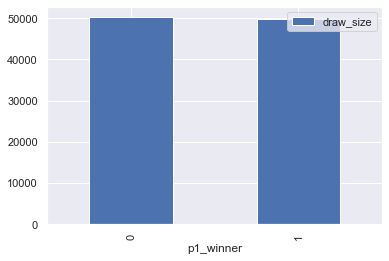

In [54]:
features[['p1_winner','draw_size']].groupby("p1_winner").count().plot(kind='bar')

## Run our dataset through Decision Tree and Grandient Boosting

In [55]:
from sklearn.model_selection import train_test_split

labels = features_diff["p1_winner"]
data = features_diff.drop(["p1_winner"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=1)

Model Score: 0.5671295369962783

ROC/AUC Score: 0.5671294050467741
              precision    recall  f1-score   support

        Loss       0.57      0.57      0.57     12502
         Win       0.57      0.57      0.57     12487

    accuracy                           0.57     24989
   macro avg       0.57      0.57      0.57     24989
weighted avg       0.57      0.57      0.57     24989

      Loss   Win
Loss  7093  5409
Win   5408  7079


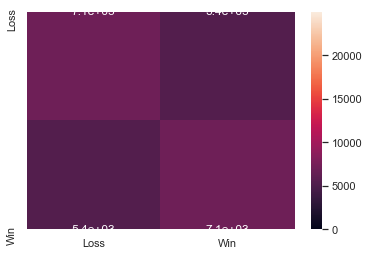

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from util.model_util import ModelWrapper
# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = "test_diff", 
                 data_file = FEATURE_FILE_DIFF,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_dt = dt.predict()
dt.analyze()

      Iter       Train Loss   Remaining Time 
         1           1.3642           14.33s
         2           1.3461           12.97s
         3           1.3314           11.99s
         4           1.3193           11.47s
         5           1.3093           11.17s
         6           1.3011           10.81s
         7           1.2942           10.48s
         8           1.2885           10.23s
         9           1.2837           10.02s
        10           1.2795            9.86s
        20           1.2602            8.16s
        30           1.2539            7.03s
        40           1.2496            5.92s
        50           1.2465            5.09s
        60           1.2443            3.94s
        70           1.2422            2.96s
Model Score: 0.6558885909800312

ROC/AUC Score: 0.6558887312233614
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66     12502
         Win       0.66      0.66      0.66     12487

   

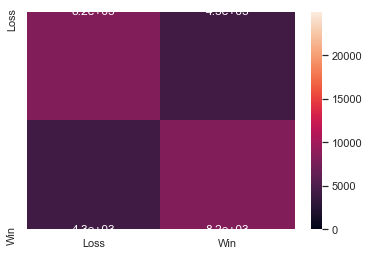

In [57]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = "test_diff", 
                 data_file = FEATURE_FILE_DIFF,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_gb = gb.predict()
gb.analyze()

# 2 - Generate Features and Ground Truth Using One Hot Encoding

For our categorical data, we are currently using label encoding. Label encoding basically assigned a unique number to each categorical value and we use this as features

Alternative method is to use one hot encoding. Each category will be coverted into a unique column - 1 will be assigned to the column if the value matches that column, all other columns will have 0 value. We will try this method to see if it makes a difference in our models

Our categories are:
* player id
* player hand
* player ioc (origin)
* tournament ID
* surface
* best_of

In [58]:
from sklearn.preprocessing import OneHotEncoder
import pickle

# def encode_columns(df: pd.DataFrame, col1: str, col2: str = None, col_labels: list = None) -> (pd.DataFrame, OneHotEncoder):
def ohe_columns(name: str, df: pd.DataFrame, col1: str, col2: str = None) -> (pd.DataFrame, OneHotEncoder):
    """
    Encodes columns and returns a DataFrame and encoder
    :param: name - encoder name to save
    :param: df - dataframe with data
    :param: col1 - name of first column to encode (ie, p1 column)
    :param: col2 - name of 2nd column to encode (ie, p2 column) - we need to do this so that the encoder knows about all values for p1 and p2
    
    :return: dataframe with encoded values and column names
    :return: encoder
    """
    encoded_return = None
    ohe = OneHotEncoder(handle_unknown='ignore', sparse = False, dtype=np.int)
    if col2:
        # sometimes not all values are in one column between p1 and p2, we have to melt them to fit the encoder
        ohe.fit(pd.melt(df[[col1, col2]])[["value"]])
        encoded_array1 = ohe.transform(df[[col1]])
        encoded_array2 = ohe.transform(df[[col2]])
        encoded_df = pd.DataFrame(encoded_array1, columns=[col1 + "_" + str(col) for col in ohe.categories_[-1]])
        encoded_df2 = pd.DataFrame(encoded_array2, columns=[col2 + "_" + str(col) for col in ohe.categories_[-1]])
        encoded_pd = pd.concat([encoded_df, encoded_df2], axis=1)
    else:
        encoded_array = ohe.fit_transform(df[[col1]])
        encoded_pd = pd.DataFrame(encoded_array, columns=[col1 + "_" + str(col) for col in ohe.categories_[-1]])

    # save off our encoder
    pickle.dump(ohe, open(f'{MODEL_DIR}/{name}_ohe.pkl', 'wb'))
    
    # drop old columns
    return_pd = pd.concat([df, encoded_pd], axis=1)
    if col2:
        return_pd = return_pd.drop([col1, col2], axis=1)
    else:
        return_pd = return_pd.drop([col1], axis=1)
    
    
    return return_pd, ohe



### let's recreate the diff dataset but we will encode categorical columns

ohe the following columns: 
player id
player hand
player ioc (origin)
tournament ID
surface

In [59]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 35 columns):
age_diff               99955 non-null float64
best_of                99955 non-null int32
draw_size              99955 non-null int32
ht_diff                99955 non-null int32
p1                     99955 non-null int32
p1_age                 99955 non-null float64
p1_hand                99955 non-null object
p1_hand_label          99955 non-null int32
p1_ht                  99955 non-null float64
p1_ioc                 99955 non-null object
p1_ioc_label           99955 non-null int32
p1_rank                99955 non-null int32
p1_seed                99955 non-null int32
p1_winner              99955 non-null int32
p2                     99955 non-null int32
p2_age                 99955 non-null float64
p2_hand                99955 non-null object
p2_hand_label          99955 non-null int32
p2_ht                  99955 non-null float64
p2_ioc                 99955 non-null obje

In [60]:
def get_reverse_map(encoder: LabelEncoder) -> dict:
    """
    reverses label encoder mapping into a dictionary so we can map values back into original values
    :param: encoder - label encoder
    :return: dict with reverse mapping from label encoder
    """
    return {i: encoder.classes_[i] for i in range(0, len(encoder.classes_))}
    

To save time, instead of iterating and recreating the data set, we are going to reverse encode columns that we encoded using label encoder

Then we will use our ohe function to one hot encode these columns into more feature columns

In [61]:
# let's make a copy of our data

# raw_feature_columns = ["best_of", "draw_size", "round_label", "surface_label", "tourney_id_label", "tourney_level_label", "tourney_month", "tourney_year",
#                    "p1", "p1_age", "p1_hand_label", "p1_ht", "p1_ioc_label", "p1_rank", "p1_seed", 
#                    "p2", "p2_age", "p2_hand_label", "p2_ht", "p2_ioc_label", "p2_rank", "p2_seed", 
#                    "p1_winner"
#                   ]
# diff_columns = ["best_of", "draw_size", "round_label", "surface_label", "tourney_id_label", "tourney_level_label", "tourney_month", "tourney_year",
#                    "p1", "p1_hand_label", "p1_ioc_label", 
#                    "p2", "p2_hand_label", "p2_ioc_label", 
#                 "age_diff", "ht_diff", "seed_diff", "rank_diff",
#                    "p1_winner"
#                   ]

ohe_cols = ["best_of", "draw_size", "round_label", "surface", "tourney_id", "tourney_level_label", "tourney_month", "tourney_year",
                   "p1", "p1_hand", "p1_ioc", 
                   "p2", "p2_hand", "p2_ioc", 
                  "age_diff", "ht_diff", "seed_diff", "rank_diff",
                   "p1_winner"
                  ]


features_diff_ohe = features[sorted(ohe_cols)].copy()

# reverse player hand
# hand_reverse_map = get_reverse_map(hand_le)
# features_ohe["p1_hand"] = features_ohe["p1_hand"].map(hand_reverse_map)
# features_ohe["p2_hand"] = features_ohe["p2_hand"].map(hand_reverse_map)

# reverse player ioc
# ioc_reverse_map = get_reverse_map(ioc_le)
# features_ohe["p1_ioc"] = features_ohe["p1_ioc"].map(ioc_reverse_map)
# features_ohe["p2_ioc"] = features_ohe["p2_ioc"].map(ioc_reverse_map)

# reverse surface
# surface_reverse_map = get_reverse_map(surface_le)
# features_ohe["surface_label"] = features_ohe["surface_label"].map(surface_reverse_map)


print(features_diff_ohe[["p1_hand", "p2_hand", "p1_ioc", "p2_ioc", "surface", "p1", "p2", "tourney_id", "best_of"]].head())

features_diff_ohe.info()

  p1_hand p2_hand p1_ioc p2_ioc surface      p1      p2 tourney_id  best_of
0       r       r    usa    nzl    hard  100617  108265        301        3
1       r       l    nzl    aus    hard  100587  100680        301        3
2       r       r    arg    aus    hard  100751  100868        301        3
3       r       r    gbr    nzl    hard  101325  100326        301        3
4       r       r    usa    nzl    hard  100761  100772        301        3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 19 columns):
age_diff               99955 non-null float64
best_of                99955 non-null int32
draw_size              99955 non-null int32
ht_diff                99955 non-null int32
p1                     99955 non-null int32
p1_hand                99955 non-null object
p1_ioc                 99955 non-null object
p1_winner              99955 non-null int32
p2                     99955 non-null int32
p2_hand                99955 non-nu

In [62]:
features_diff_ohe, hand_ohe = ohe_columns("hand", features_diff_ohe, "p1_hand", "p2_hand")
features_diff_ohe, surface_ohe = ohe_columns("surface", features_diff_ohe, "surface")
features_diff_ohe, ioc_ohe = ohe_columns("ioc", features_diff_ohe, "p1_ioc", "p2_ioc")
features_diff_ohe, tourney_id_ohe = ohe_columns("tourney_id", features_diff_ohe, "tourney_id")
features_diff_ohe, player_id_ohe = ohe_columns("player_id", features_diff_ohe, "p1", "p2")
features_diff_ohe, best_of_ohe = ohe_columns("best_of", features_diff_ohe, "best_of")

features_diff_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Columns: 5254 entries, age_diff to best_of_5
dtypes: float64(1), int32(9), int64(5244)
memory usage: 3.9 GB


In [74]:
features_diff_ohe = features_diff_ohe.reindex(sorted(features_diff_ohe.columns), axis=1)
features_diff_ohe.head()

,age_diff,best_of_3,best_of_5,draw_size,ht_diff,p1_100221,p1_100240,p1_100241,p1_100252,p1_100253,...,tourney_id_m016,tourney_id_m020,tourney_id_m021,tourney_id_m024,tourney_id_m035,tourney_id_m052,tourney_id_o16,tourney_level_label,tourney_month,tourney_year
0,0.741947,1,0,32,-5,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1986
1,1.210000,1,0,32,10,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1986
2,1.370000,1,0,32,-3,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1986
3,-12.920000,1,0,32,-10,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1986
4,0.150000,1,0,32,18,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1986


In [75]:
features_diff_ohe.to_csv(FEATURE_FILE_DIFF_OHE, index=False)

In [76]:
features_diff_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Columns: 5254 entries, age_diff to tourney_year
dtypes: float64(1), int32(9), int64(5244)
memory usage: 3.9 GB


In [77]:
features_diff_ohe.shape

(99955, 5254)

## We will use raw data and encode categorical columns

In [78]:

raw_ohe_columns = ["best_of", "draw_size", "round_label", "surface", "tourney_id", "tourney_level_label", "tourney_month", "tourney_year",
                   "p1", "p1_age", "p1_hand", "p1_ht", "p1_ioc", "p1_rank", "p1_seed", 
                   "p2", "p2_age", "p2_hand", "p2_ht", "p2_ioc", "p2_rank", "p2_seed", 
                   "p1_winner"
                  ]

features_ohe = features[sorted(raw_ohe_columns)].copy()
print(features_ohe[["p1_hand", "p2_hand", "p1_ioc", "p2_ioc", "surface", "p1", "p2", "tourney_id", "best_of"]].head())


  p1_hand p2_hand p1_ioc p2_ioc surface      p1      p2 tourney_id  best_of
0       r       r    usa    nzl    hard  100617  108265        301        3
1       r       l    nzl    aus    hard  100587  100680        301        3
2       r       r    arg    aus    hard  100751  100868        301        3
3       r       r    gbr    nzl    hard  101325  100326        301        3
4       r       r    usa    nzl    hard  100761  100772        301        3


In [79]:
features_ohe, hand_ohe = ohe_columns("hand", features_ohe, "p1_hand", "p2_hand")
features_ohe, surface_ohe = ohe_columns("surface", features_ohe, "surface")
features_ohe, ioc_ohe = ohe_columns("ioc", features_ohe, "p1_ioc", "p2_ioc")
features_ohe, tourney_id_ohe = ohe_columns("tourney_id", features_ohe, "tourney_id")
features_ohe, player_id_ohe = ohe_columns("player_id", features_ohe, "p1", "p2")
features_ohe, best_of_ohe = ohe_columns("best_of", features_ohe, "best_of")



In [80]:
features_ohe = features_ohe.reindex(sorted(features_ohe.columns), axis=1)
features_ohe.head()

,best_of_3,best_of_5,draw_size,p1_100221,p1_100240,p1_100241,p1_100252,p1_100253,p1_100273,p1_100276,...,tourney_id_m016,tourney_id_m020,tourney_id_m021,tourney_id_m024,tourney_id_m035,tourney_id_m052,tourney_id_o16,tourney_level_label,tourney_month,tourney_year
0,1,0,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1986
1,1,0,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1986
2,1,0,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1986
3,1,0,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1986
4,1,0,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1986


In [81]:
features_ohe.to_csv(FEATURE_FILE_OHE, index=False)
features_ohe.shape

(99955, 5258)

# Create dataset with both raw and diff data

In [82]:

raw_diff_ohe_columns = ["best_of", "draw_size", "round_label", "surface", "tourney_id", "tourney_level_label", "tourney_month", "tourney_year",
                   "p1", "p1_age", "p1_hand", "p1_ht", "p1_ioc", "p1_rank", "p1_seed", 
                   "p2", "p2_age", "p2_hand", "p2_ht", "p2_ioc", "p2_rank", "p2_seed", 
                  "age_diff", "ht_diff", "seed_diff", "rank_diff",
                   "p1_winner"
                  ]



features_raw_diff_ohe = features[sorted(raw_diff_ohe_columns)].copy()
print(features_raw_diff_ohe[["p1_hand", "p2_hand", "p1_ioc", "p2_ioc", "surface", "p1", "p2", "tourney_id", "best_of"]].head())


  p1_hand p2_hand p1_ioc p2_ioc surface      p1      p2 tourney_id  best_of
0       r       r    usa    nzl    hard  100617  108265        301        3
1       r       l    nzl    aus    hard  100587  100680        301        3
2       r       r    arg    aus    hard  100751  100868        301        3
3       r       r    gbr    nzl    hard  101325  100326        301        3
4       r       r    usa    nzl    hard  100761  100772        301        3


In [83]:
features_raw_diff_ohe, hand_ohe = ohe_columns("hand", features_raw_diff_ohe, "p1_hand", "p2_hand")
features_raw_diff_ohe, surface_ohe = ohe_columns("surface", features_raw_diff_ohe, "surface")
features_raw_diff_ohe, ioc_ohe = ohe_columns("ioc", features_raw_diff_ohe, "p1_ioc", "p2_ioc")
features_raw_diff_ohe, tourney_id_ohe = ohe_columns("tourney_id", features_raw_diff_ohe, "tourney_id")
features_raw_diff_ohe, player_id_ohe = ohe_columns("player_id", features_raw_diff_ohe, "p1", "p2")
features_raw_diff_ohe, best_of_ohe = ohe_columns("best_of", features_raw_diff_ohe, "best_of")



In [84]:
features_raw_diff_ohe = features_raw_diff_ohe.reindex(sorted(features_raw_diff_ohe.columns), axis=1)
features_raw_diff_ohe.head()

,age_diff,best_of_3,best_of_5,draw_size,ht_diff,p1_100221,p1_100240,p1_100241,p1_100252,p1_100253,...,tourney_id_m016,tourney_id_m020,tourney_id_m021,tourney_id_m024,tourney_id_m035,tourney_id_m052,tourney_id_o16,tourney_level_label,tourney_month,tourney_year
0,0.741947,1,0,32,-5,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1986
1,1.210000,1,0,32,10,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1986
2,1.370000,1,0,32,-3,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1986
3,-12.920000,1,0,32,-10,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1986
4,0.150000,1,0,32,18,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1986


In [85]:
# print out our non-encoded columns
import re
print([col for col in features_raw_diff_ohe.columns if not re.match(r'(p1|p2)_[\d]+', col) and not re.match(r"(p1|p2)_ioc_", col) and not re.match("tourney_id_", col)])

['age_diff', 'best_of_3', 'best_of_5', 'draw_size', 'ht_diff', 'p1_age', 'p1_hand_l', 'p1_hand_r', 'p1_hand_u', 'p1_ht', 'p1_rank', 'p1_seed', 'p1_winner', 'p2_age', 'p2_hand_l', 'p2_hand_r', 'p2_hand_u', 'p2_ht', 'p2_rank', 'p2_seed', 'rank_diff', 'round_label', 'seed_diff', 'surface_carpet', 'surface_clay', 'surface_grass', 'surface_hard', 'tourney_level_label', 'tourney_month', 'tourney_year']


In [86]:
features_raw_diff_ohe.to_csv(FEATURE_FILE_RAW_DIFF_OHE, index=False)
features_raw_diff_ohe.shape

(99955, 5262)